In [3]:
import requests
from datetime import date, timedelta
import pandas as pd

url = "https://api.coingecko.com/api/v3/coins/bitcoin/history?date="

headers = {
    "accept": "application/json",
    "x-cg-demo-api-key": "CG-XNGBRE1zynSYLPRSQhjN7n2v"
}


def daterange(start_date: date, end_date: date):
    days = int((end_date - start_date).days)
    for n in range(days):
        yield start_date + timedelta(n)

start_date = date(2025, 4, 1)
end_date = date(2025, 4, 14)
res = []
for single_date in daterange(start_date, end_date):
    response = requests.get(url + single_date.strftime("%d-%m-%Y") + "&localization=false", headers=headers)
    data = response.json()
    res.append({
        "date" : single_date, 
        "price" : data["market_data"]["current_price"]["usd"], 
        "total volume" : data["market_data"]["total_volume"]["usd"],
        "market cap" : data["market_data"]["market_cap"]["usd"]})

df = pd.DataFrame(res)

print(df)


          date         price  total volume    market cap
0   2025-04-01  82514.093654  3.032615e+10  1.635077e+12
1   2025-04-02  85237.587605  2.917290e+10  1.690602e+12
2   2025-04-03  82526.422153  4.633291e+10  1.637359e+12
3   2025-04-04  83163.987574  3.659446e+10  1.652537e+12
4   2025-04-05  83852.007654  3.564729e+10  1.664235e+12
5   2025-04-06  83595.885502  1.491040e+10  1.656020e+12
6   2025-04-07  78211.483582  3.614038e+10  1.555325e+12
7   2025-04-08  79179.292268  8.290975e+10  1.581408e+12
8   2025-04-09  76329.090356  4.781279e+10  1.515042e+12
9   2025-04-10  82622.170295  8.740822e+10  1.640568e+12
10  2025-04-11  79596.357323  4.121352e+10  1.580023e+12
11  2025-04-12  83439.288180  3.981357e+10  1.655869e+12
12  2025-04-13  85305.097284  2.242893e+10  1.693601e+12


{'prices': [[1744992370557, 84382.34027186113], [1744996046835, 84455.82994619277], [1744999491703, 84543.02354629472], [1745003028592, 84599.59333023877], [1745006854135, 84535.96965601825], [1745010295138, 84495.66839467015], [1745013896604, 84589.93551188768], [1745017449563, 84507.5553544359], [1745021090927, 84447.77718147618], [1745024692944, 84430.13416891031], [1745028293988, 84537.56876723397], [1745031879291, 84750.96113857607], [1745035494282, 84873.33303095314], [1745039096887, 85039.73101895596], [1745042815197, 85065.22675131068], [1745046568012, 84928.93649119227], [1745049878713, 85188.51899516837], [1745053487420, 85315.77967080926], [1745057097504, 85348.12052038811], [1745060691582, 85222.96773135632], [1745064278460, 85196.3572478893], [1745067652596, 85277.07094440877], [1745071479991, 85450.83762577904], [1745075366840, 85405.39779525725], [1745078694075, 85216.9255110766], [1745082288535, 84884.07476220753], [1745085887543, 85152.68414164294], [1745089497549, 851

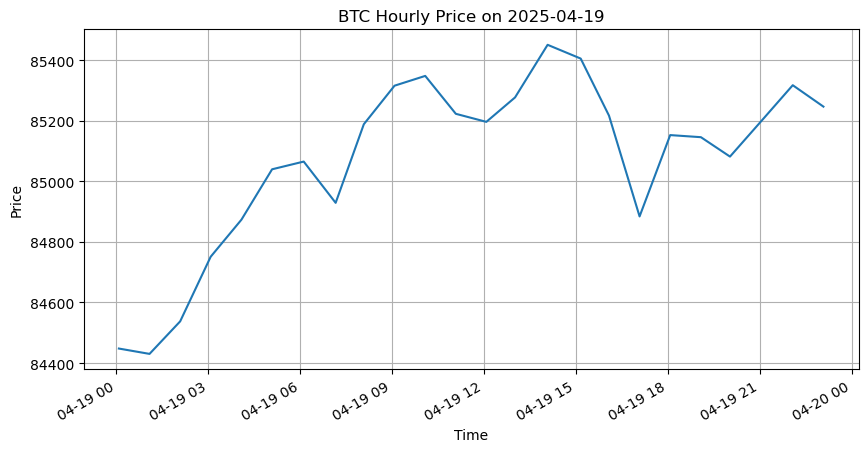

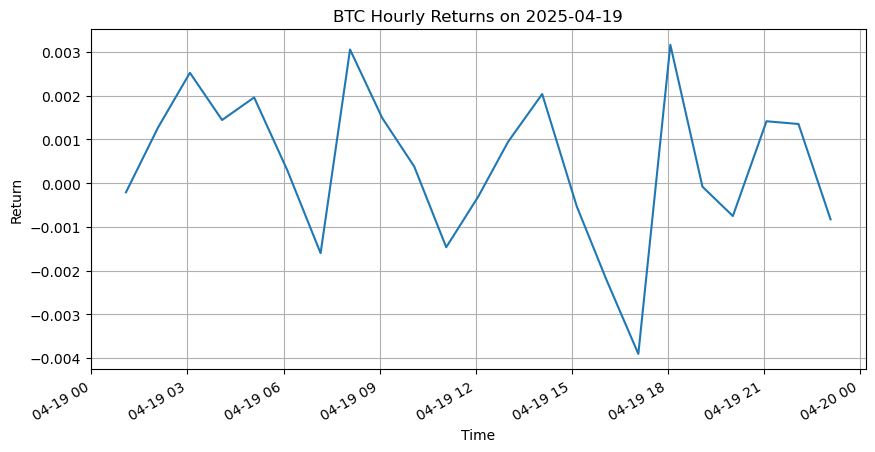

Votatility or Standard Deviation for 24h : 0.001749


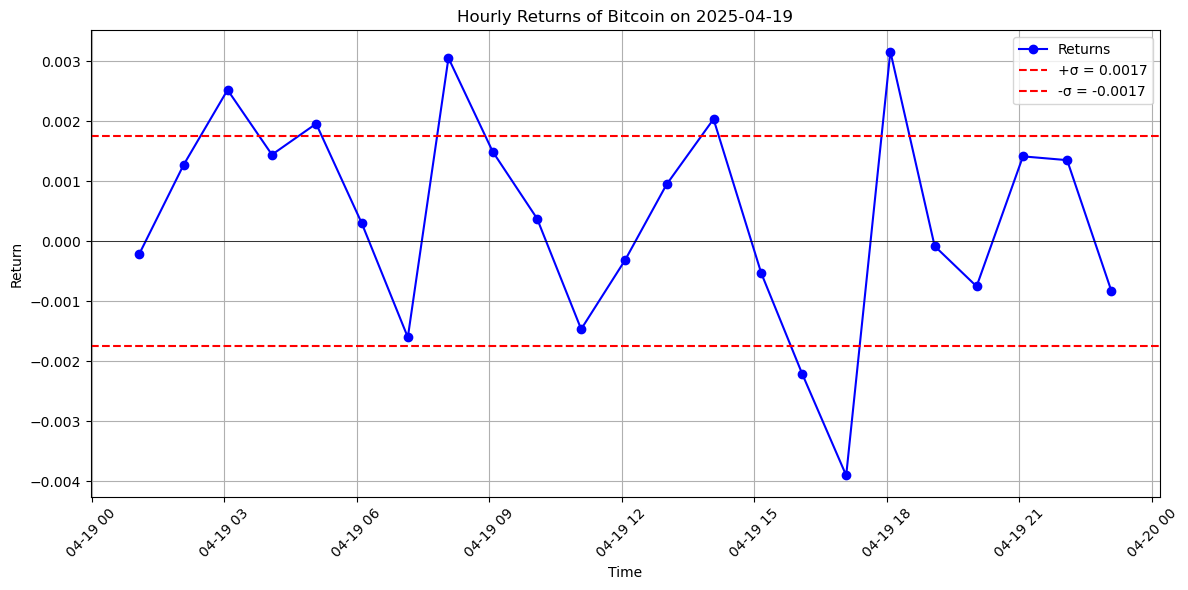

In [ ]:
import matplotlib.pyplot as plt

url = "https://api.coingecko.com/api/v3/coins/bitcoin/market_chart"

params = {
    'vs_currency' : 'usd',
    'days' : '2', # set 2 days to analyse actually only one to escape error about free version
}

headers = {
    "accept": "application/json",
    "x-cg-demo-api-key": "CG-XNGBRE1zynSYLPRSQhjN7n2v"
}

response = requests.get(url, params=params, headers=headers)
data = response.json()
#print(data)
prices = pd.DataFrame(data['prices'],columns=['timestamp','price']) 

prices['timestamp'] = pd.to_datetime(prices['timestamp'], unit = 'ms')
prices.set_index('timestamp', inplace = True)

day_to_analyse = pd.to_datetime('2025-04-19') # set one date
next_day = day_to_analyse + pd.Timedelta(days=1) # set the second day
prices = prices[(prices.index >= day_to_analyse) & (prices.index < next_day)] # extract only one of these to to analyse one day hourly(default)

prices['return'] = prices['price'].pct_change() # calculate the percentage change from hour to hour (returns)

volatility = prices['return'].std() # calculate standard deviation of these returns (volatility)

print(prices)
print(f'Volatility of Bitcoin for last 24 hours:{volatility:.4f}')

prices['price'].plot(title=f'BTC Hourly Price on {day_to_analyse.date()}', figsize=(10,5))  # visualising price
plt.xlabel('Time')
plt.ylabel('Price')
plt.grid(True)
plt.show()

prices['return'].plot(title=f'BTC Hourly Returns on {day_to_analyse.date()}',figsize=(10,5)) #visualising returns
plt.xlabel('Time')
plt.ylabel('Return')
plt.grid(True)
plt.show()
print(f'Votatility or Standard Deviation for 24h : {volatility:4f}')



plt.figure(figsize=(12, 6))
# Returns
plt.plot(prices.index, prices['return'], marker='o', linestyle='-', color='blue', label='Returns')

# adding standard deviation
plt.axhline(y=volatility, color='red', linestyle='--', label=f'+σ = {volatility:.4f}')
plt.axhline(y=-volatility, color='red', linestyle='--', label=f'-σ = {-volatility:.4f}')
plt.axhline(y=0, color='black', linestyle='-', linewidth=0.5)

plt.title('Hourly Returns of Bitcoin on 2025-04-19')
plt.xlabel('Time')
plt.ylabel('Return')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()




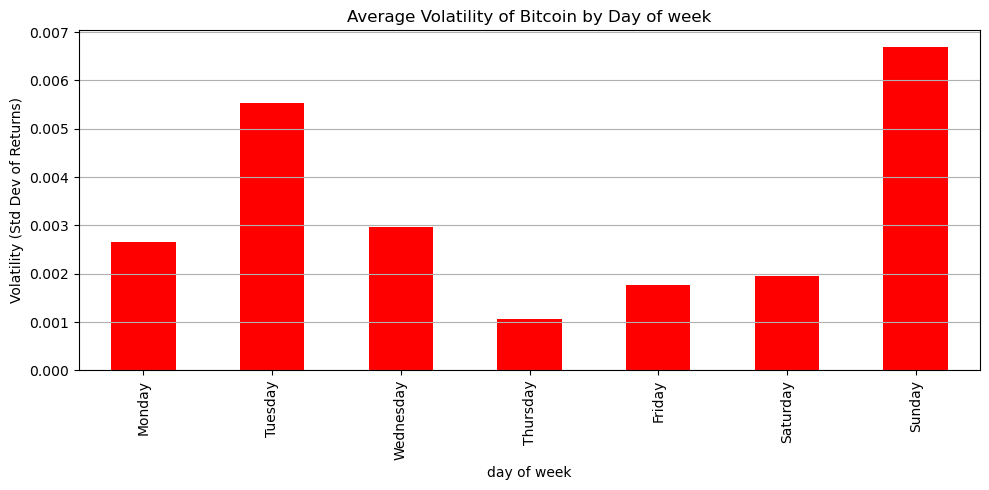

In [61]:
#Weekly Volatility 

import matplotlib.pyplot as plt
from datetime import datetime, timedelta

results = [] 

for i in range(1,8):  # loop to analyse every day hourly from selected (today-n) days until today
    day = datetime.today() - timedelta(days=i) 
    next_day = day + timedelta(days=1)

    url = "https://api.coingecko.com/api/v3/coins/bitcoin/market_chart"
    params = {
     'vs_currency' : 'usd',
      'days' : '7', # by changing days dont forget to change the loop too
    }

    headers = {
     "accept": "application/json",
     "x-cg-demo-api-key": "CG-XNGBRE1zynSYLPRSQhjN7n2v"
    }

    response = requests.get(url, params=params, headers=headers)
    data = response.json()
    #print(data)

    prices = pd.DataFrame(data['prices'],columns=['timestamp','price']) 
    prices['timestamp'] = pd.to_datetime(prices['timestamp'], unit = 'ms')
    prices.set_index('timestamp', inplace = True)

    daily = prices[(prices.index >= day) & (prices.index < next_day)] #new list with prices by day
    daily= daily.copy()
    daily['return'] = daily['price'].pct_change() # calculating hourly returns for every day
    volatility = daily['return'].std() # calculating std dev for every day in week
    results.append({ # adding result to new the empty list
       'date': day.date(),
       'weekday' : day.strftime('%A'),
       'volatility' : volatility
    })

df = pd.DataFrame(results) 
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df['weekday'] = pd.Categorical(df['weekday'],categories=weekday_order, ordered=True) #set right order of weekdays (default alphabetical order)
#print(df)
grouped = df.groupby('weekday', observed=True)['volatility'].mean() # group calculated average of std devs by weekday
#print(grouped)

plt.figure(figsize=(10,5))
grouped.plot(kind='bar', color='red')
plt.title('Average Volatility of Bitcoin by Day of week')
plt.xlabel('day of week')
plt.ylabel('Volatility (Std Dev of Returns)')
plt.grid(axis='y')
plt.tight_layout()
plt.show()


                         total_volume
timestamp                            
2025-04-19 00:04:50.927  9.519084e+09
2025-04-19 01:04:52.944  9.382420e+09
2025-04-19 02:04:53.988  9.014769e+09
2025-04-19 03:04:39.291  9.336293e+09
2025-04-19 04:04:54.282  9.829576e+09
2025-04-19 05:04:56.887  1.038277e+10
2025-04-19 06:06:55.197  1.035712e+10
2025-04-19 07:09:28.012  1.045605e+10
2025-04-19 08:04:38.713  1.040325e+10
2025-04-19 09:04:47.420  1.026395e+10
2025-04-19 10:04:57.504  1.066291e+10
2025-04-19 11:04:51.582  1.062014e+10
2025-04-19 12:04:38.460  1.071035e+10
2025-04-19 13:00:52.596  1.066041e+10
2025-04-19 14:04:39.991  1.084292e+10
2025-04-19 15:09:26.840  1.079403e+10
2025-04-19 16:04:54.075  1.178499e+10
2025-04-19 17:04:48.535  1.235323e+10
2025-04-19 18:04:47.543  1.284756e+10
2025-04-19 19:04:57.549  1.304748e+10
2025-04-19 20:01:54.415  1.287291e+10
2025-04-19 21:04:53.819  1.286995e+10
2025-04-19 22:04:51.622  1.286819e+10
2025-04-19 23:04:56.247  1.273128e+10


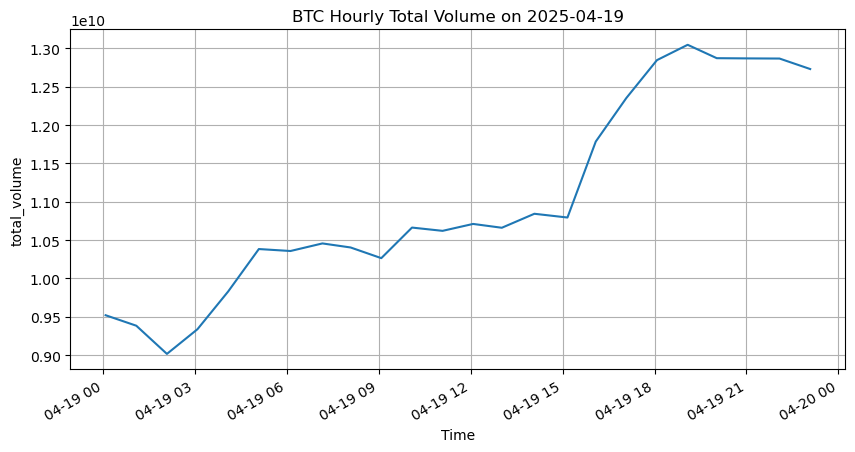

In [ ]:
#Hourly Total Volume

import matplotlib.pyplot as plt

url = "https://api.coingecko.com/api/v3/coins/bitcoin/market_chart"

params = {
    'vs_currency' : 'usd',
    'days' : '2', # set 2 days to analyse actually only one to escape error about free version possibilities
}

headers = {
    "accept": "application/json",
    "x-cg-demo-api-key": "CG-XNGBRE1zynSYLPRSQhjN7n2v"
}

response = requests.get(url, params=params, headers=headers)
data = response.json()
#print(data)
total_volumes = pd.DataFrame(data['total_volumes'],columns=['timestamp','total_volume']) 

total_volumes['timestamp'] = pd.to_datetime(total_volumes['timestamp'], unit = 'ms')
total_volumes.set_index('timestamp', inplace = True)

day_to_analyse = pd.to_datetime('2025-04-19') # set one date
next_day = day_to_analyse + pd.Timedelta(days=1) # set the second day
total_volumes = total_volumes[(total_volumes.index >= day_to_analyse) & (total_volumes.index < next_day)] 

print(total_volumes)

total_volumes['total_volume'].plot(title=f'BTC Hourly Total Volume on {day_to_analyse.date()}', figsize=(10,5))  # visualising price
plt.xlabel('Time')
plt.ylabel('total_volume')
plt.grid(True)
plt.show()


                         total_volume
timestamp                            
2025-04-13 19:04:52.667  2.589543e+10
2025-04-13 20:08:15.724  2.725692e+10
2025-04-13 21:04:38.302  2.596146e+10
2025-04-13 22:04:40.265  2.685945e+10
2025-04-13 23:04:57.456  2.821980e+10
...                               ...
2025-04-20 15:04:40.110  1.274083e+10
2025-04-20 16:04:44.724  1.198393e+10
2025-04-20 17:04:34.686  1.140759e+10
2025-04-20 18:04:48.198  1.117858e+10
2025-04-20 19:20:46.000  1.092349e+10

[169 rows x 1 columns]


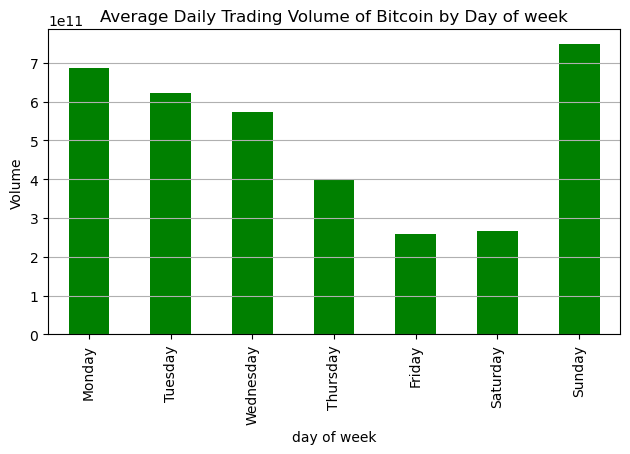

KeyError: 'volatility'

In [ ]:
#Hourly Total Volume

import matplotlib.pyplot as plt

url = "https://api.coingecko.com/api/v3/coins/bitcoin/market_chart"

params = {
    'vs_currency' : 'usd',
    'days' : '7', # set 2 days to analyse actually only one to escape error about free version possibilities
}

headers = {
    "accept": "application/json",
    "x-cg-demo-api-key": "CG-XNGBRE1zynSYLPRSQhjN7n2v"
}

response = requests.get(url, params=params, headers=headers)
data = response.json()
#print(data)
total_volumes = pd.DataFrame(data['total_volumes'],columns=['timestamp','total_volume']) 

total_volumes['timestamp'] = pd.to_datetime(total_volumes['timestamp'], unit = 'ms')
total_volumes.set_index('timestamp', inplace = True)
print(total_volumes)

results = [] 
for i in range(1,8):
   day = datetime.today() - timedelta(days=i)
   next_day = day + timedelta(days=1)

   daily = total_volumes[(total_volumes.index >= day) & (total_volumes.index < next_day)] #new list with total_volumes by day
   daily= daily.copy()
   avg_volume = daily['total_volume'].sum() # calculating std dev for every day in week
   results.append({ # adding result to new the empty list
       'date': day.date(),
       'weekday' : day.strftime('%A'),
       'volume' : avg_volume
    })

df = pd.DataFrame(results) 
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df['weekday'] = pd.Categorical(df['weekday'],categories=weekday_order, ordered=True) #set right order of weekdays (default alphabetical order)
grouped = df.groupby('weekday', observed=True)['volume'].mean() # group calculated average of std devs by weekday

grouped.plot(kind='bar', color='green')
plt.title('Average Daily Trading Volume of Bitcoin by Day of week')
plt.xlabel('day of week')
plt.ylabel('Volume')
plt.grid(axis='y')
plt.tight_layout()
plt.show()


KeyError: 'weekday'

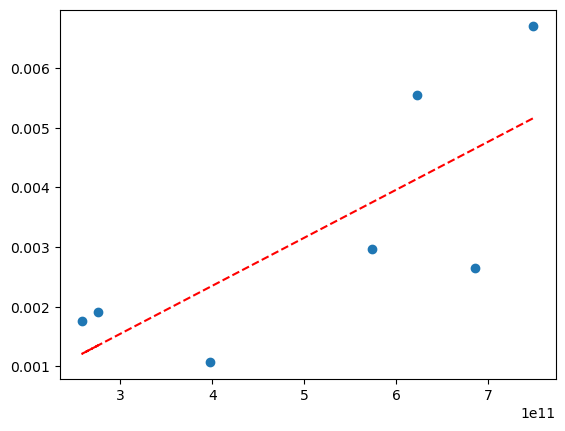

In [89]:
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import numpy as np

results_vl = [] 

for i in range(1,8):  # loop to analyse every day hourly from selected (today-n) days until today
    day = datetime.today() - timedelta(days=i) 
    next_day = day + timedelta(days=1)

    url = "https://api.coingecko.com/api/v3/coins/bitcoin/market_chart"
    params = {
     'vs_currency' : 'usd',
      'days' : '7', # by changing days dont forget to change the loop too
    }

    headers = {
     "accept": "application/json",
     "x-cg-demo-api-key": "CG-XNGBRE1zynSYLPRSQhjN7n2v"
    }

    response = requests.get(url, params=params, headers=headers)
    data = response.json()
    #print(data)

    prices = pd.DataFrame(data['prices'],columns=['timestamp','price']) 
    prices['timestamp'] = pd.to_datetime(prices['timestamp'], unit = 'ms')
    prices.set_index('timestamp', inplace = True)

    daily_vl = prices[(prices.index >= day) & (prices.index < next_day)] #new list with prices by day
    daily_vl= daily_vl.copy()
    daily_vl['return'] = daily_vl['price'].pct_change() # calculating hourly returns for every day
    volatility = daily_vl['return'].std() # calculating std dev for every day in week
    results_vl.append({ # adding result to new the empty list
       'date': day.date(),
       'weekday' : day.strftime('%A'),
       'volatility' : volatility
    })

df_vl = pd.DataFrame(results_vl) 
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df_vl['weekday'] = pd.Categorical(df_vl['weekday'],categories=weekday_order, ordered=True) #set right order of weekdays (default alphabetical order)
grouped_vl = df_vl.groupby('weekday', observed=True)['volatility'].mean() # group calculated average of std devs by weekday



total_volumes = pd.DataFrame(data['total_volumes'],columns=['timestamp','total_volume']) 
total_volumes['timestamp'] = pd.to_datetime(total_volumes['timestamp'], unit = 'ms')
total_volumes.set_index('timestamp', inplace = True)

results_tv = [] 
for i in range(1,8):
   day = datetime.today() - timedelta(days=i)
   next_day = day + timedelta(days=1)

   daily_tv = total_volumes[(total_volumes.index >= day) & (total_volumes.index < next_day)] #new list with total_volumes by day
   daily_tv= daily_tv.copy()
   avg_volume = daily_tv['total_volume'].sum() # calculating std dev for every day in week
   results_tv.append({ # adding result to new the empty list
       'date': day.date(),
       'weekday' : day.strftime('%A'),
       'volume' : avg_volume
    })

df_tv = pd.DataFrame(results_tv) 
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df_tv['weekday'] = pd.Categorical(df_tv['weekday'],categories=weekday_order, ordered=True) #set right order of weekdays (default alphabetical order)
grouped_tv = df_tv.groupby('weekday', observed=True)['volume'].mean() # group calculated average of std devs by weekday

df_combined = pd.merge(df_tv, df_vl, on='date')
plt.scatter(df_combined['volume'], df_combined['volatility'])
corr = df_combined['volume'].corr(df_combined['volatility'])
m,b = np.polyfit(df_combined['volume'],df_combined['volatility'],1)
plt.plot(df_combined['volume'], m*df_combined['volume'] +b,color='red', linestyle='--')
for i, row in df_combined.iterrows():
    plt.annotate(row['weekday'], (row['volume'], row['volatility']))
print(f'Correlation: {corr}')
